In [1]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from sklearn.metrics import silhouette_score

# from sklearn.exceptions import ConvergenceWarning
# warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
pca_df = pd.read_csv('pca_df.csv')
df_subset = pd.read_csv('df_subset.csv')

In [82]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089', 
               '#AF6E4D', '#4C5866', '#8A9694', '#EBB769', '#5B458F', '#37777D', '#BB7E5D', '#275943']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

# Model based clustering

## Gaussian Mixture

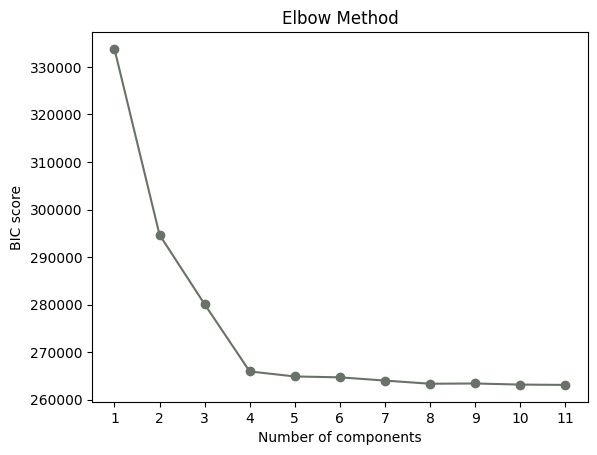

In [4]:
n_components_range = range(1, 12)
bic_scores = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(pca_df)
    bic_scores.append(gmm.bic(pca_df))

# Plot the BIC scores against the number of components
plt.plot(n_components_range, bic_scores, marker='o', color = '#697268')
plt.xlabel('Number of components')
plt.ylabel('BIC score')
plt.title('Elbow Method')
plt.xticks(n_components_range)
plt.show()

BIC (Bayesian Information Criterion) is given by the formula: BIC = -2 * loglikelihood + d * log(N), where N is the sample size of the training set and d is the total number of parameters. The lower BIC score signals a better model.

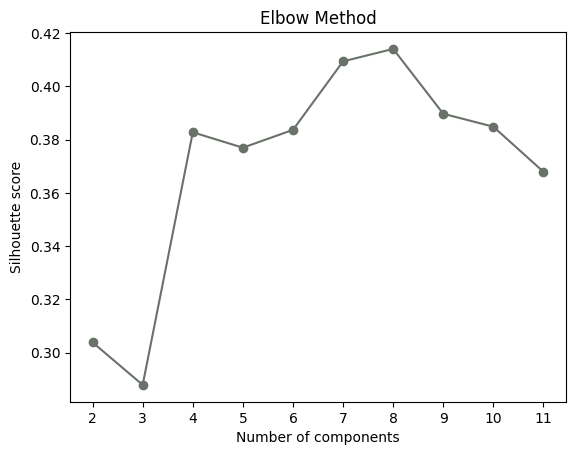

In [5]:
n_components_range = range(2, 12)  
silhouette_scores = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(pca_df)
    labels = gmm.predict(pca_df)
    silhouette_scores.append(silhouette_score(pca_df, labels))

plt.plot(n_components_range, silhouette_scores, marker='o', color = '#697268')
plt.xlabel('Number of components')
plt.ylabel('Silhouette score')
plt.title('Elbow Method')
plt.xticks(n_components_range)
plt.show()


8: high silhouette score and low BIC

In [25]:
gaussian_mix = GaussianMixture(n_components=8, random_state=42, verbose=1)
gaussian_mix.fit(pca_df)

Initialization 0
Initialization converged: True


GaussianMixture(n_components=8, random_state=42, verbose=1)

In [26]:
with open('results/model_based/gaussian_mix.pickle', 'wb') as f:
    pickle.dump(gaussian_mix, f)

In [27]:
with open('results/model_based/gaussian_mix.pickle', 'rb') as f:
    gaussian_mix = pickle.load(f)

In [28]:
labels = gaussian_mix.predict(pca_df)

In [29]:
len(np.unique(labels))

8

In [34]:
pca_df = pca_df.loc[:,:'PC2']

In [35]:
pca_df['cluster_label'] = labels
pca_df['asset_id'] = df_subset['asset_id']

In [36]:
pca_df.to_csv('results/model_based/csv_labels_cut_raw/gaussian_mix.csv', index = False)

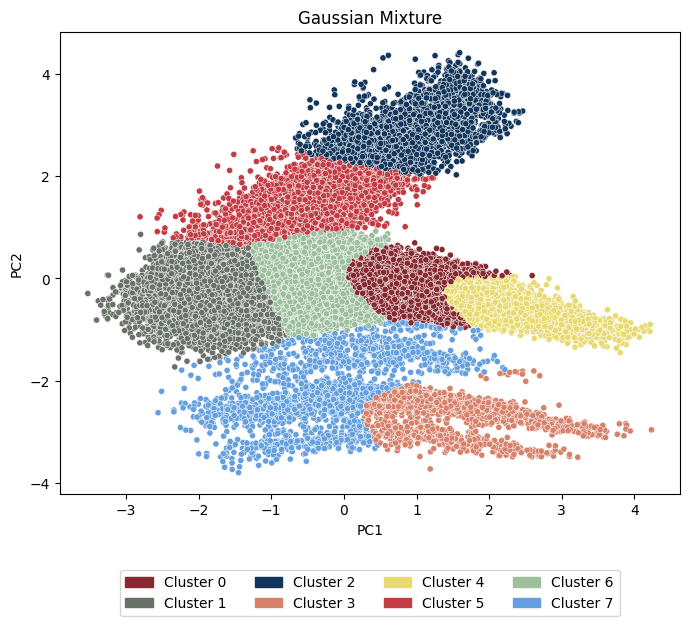

In [37]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [38]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns= 'cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-1.163049,-2.596939,11,3
1,1.722822,-2.602608,11,3
2,1.451641,-2.588719,11,3
3,0.734407,-2.237956,11,3
4,0.121023,-2.182634,11,3


In [39]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-1.163049,-2.596939,11,3
1,1.722822,-2.602608,11,3
2,1.451641,-2.588719,11,3
3,0.734407,-2.237956,11,3
4,0.121023,-2.182634,11,3


In [40]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-1.163049,-2.596939,3
1,12,2.651199,-3.422293,3
2,13,1.451020,-0.049027,6
3,14,1.304045,-0.185737,6
4,15,2.222184,-0.592280,6
...,...,...,...,...
72,510,0.207552,2.331831,2
73,511,1.209865,3.228942,2
74,512,-0.236960,0.793759,2
75,513,1.510521,3.365319,2


In [41]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [20, 21, 23, 26, 31, 45, 46, 56]
Cluster 1: [9, 10, 11, 13, 15, 16, 17, 48, 49, 50, 53, 54, 55]
Cluster 2: [37, 40, 44, 72, 73, 74, 75, 76]
Cluster 3: [0, 1, 52, 58]
Cluster 4: [14]
Cluster 5: [36, 38, 39, 41, 42, 43]
Cluster 6: [2, 3, 4, 5, 6, 7, 8, 12, 18, 19, 22, 24, 25, 27, 28, 29, 30, 32, 34, 35, 47, 51, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
Cluster 7: [33]


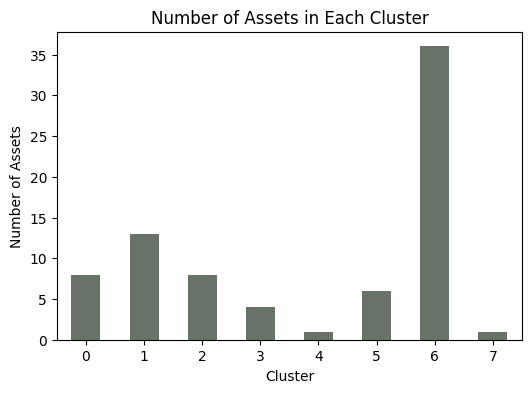

In [42]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [43]:
pca_df.to_csv('results/model_based/labels_most_common/gaussian_mix.csv', index= False)

In [44]:
pca_df = pca_df.loc[:,:'PC2']

## Bayesian GMM

BayesianGaussianMixture has no atribute bic, so it's not possible to computre the elbow method for the bic scores

/home/sara/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/m

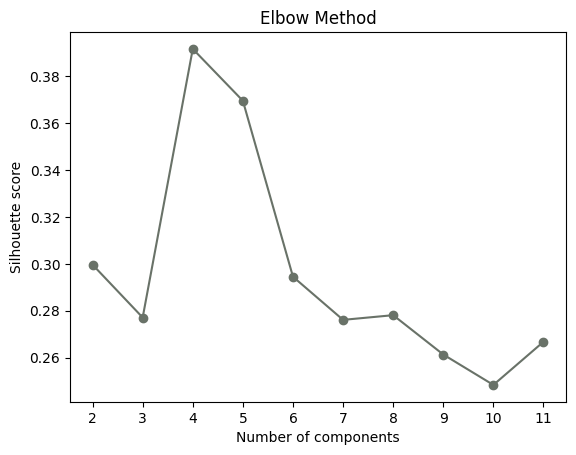

In [45]:
n_components_range = range(2, 12)  
silhouette_scores = []
for n_components in n_components_range:
    bgmm = BayesianGaussianMixture(n_components=n_components, covariance_type='full', max_iter=1000, random_state=42, tol=1e-6)
    bgmm.fit(pca_df)
    labels = bgmm.predict(pca_df)
    silhouette_scores.append(silhouette_score(pca_df, labels))

plt.plot(n_components_range, silhouette_scores, marker='o', color = '#697268')
plt.xlabel('Number of components')
plt.ylabel('Silhouette score')
plt.title('Elbow Method')
plt.xticks(n_components_range)
plt.show()


In [46]:
# Fitting Bayesian Gaussian Mixture Model
bgmm = BayesianGaussianMixture(n_components=4, covariance_type='full', max_iter=1000, random_state=42, tol=1e-6)
bgmm.fit(pca_df)

# Predicting clusters for data points
labels = bgmm.predict(pca_df)

In [47]:
with open('results/model_based/bgmm.pickle', 'wb') as f:
    pickle.dump(bgmm, f)

In [48]:
with open('results/model_based/bgmm.pickle', 'rb') as f:
    bgmm = pickle.load(f)

In [49]:
labels = bgmm.predict(pca_df)

In [50]:
pca_df = pca_df.loc[:,:'PC2']

In [51]:
pca_df['cluster_label'] = labels
pca_df['asset_id'] = df_subset['asset_id']

In [52]:
pca_df.to_csv('results/model_based/csv_labels_cut_raw/bgmm.csv', index = False)

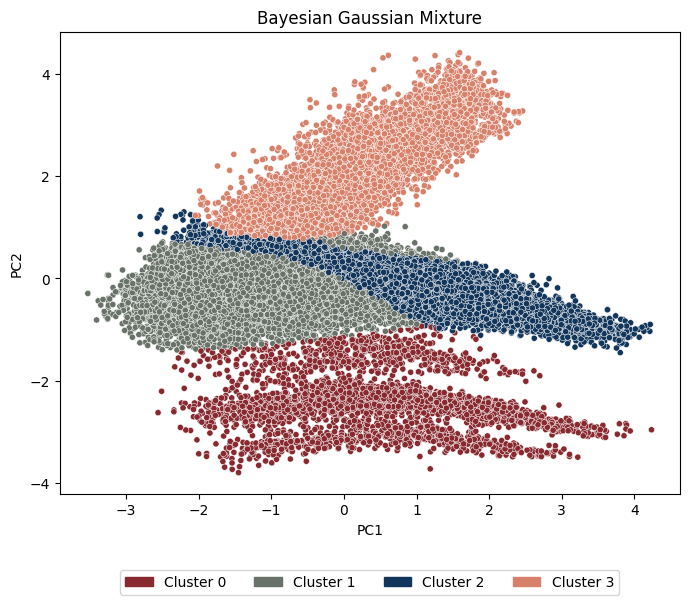

In [53]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('Bayesian Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [54]:
len(np.unique(labels))

4

In [55]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns = 'cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-1.163049,-2.596939,11,0
1,1.722822,-2.602608,11,0
2,1.451641,-2.588719,11,0
3,0.734407,-2.237956,11,0
4,0.121023,-2.182634,11,0


In [56]:
len(most_frequent_clusters.unique())

4

In [57]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-1.163049,-2.596939,0
1,12,2.651199,-3.422293,0
2,13,1.451020,-0.049027,2
3,14,1.304045,-0.185737,2
4,15,2.222184,-0.592280,2
...,...,...,...,...
72,510,0.207552,2.331831,3
73,511,1.209865,3.228942,3
74,512,-0.236960,0.793759,3
75,513,1.510521,3.365319,3


In [58]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 33, 52, 58]
Cluster 1: [13, 14, 15, 17, 19, 24, 26, 27, 30, 32, 50, 51, 55, 59, 60, 61, 62, 63, 64, 68, 69]
Cluster 2: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 18, 20, 21, 22, 23, 25, 28, 29, 31, 34, 35, 45, 46, 47, 48, 49, 53, 54, 56, 57, 65, 66, 67, 70, 71]
Cluster 3: [36, 37, 38, 39, 40, 41, 42, 43, 44, 72, 73, 74, 75, 76]


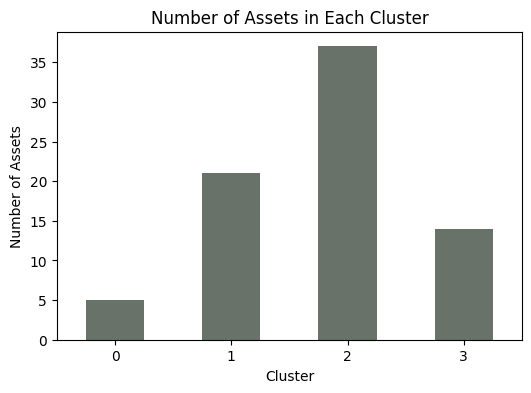

In [59]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [60]:
pca_df.to_csv('results/model_based/labels_most_common/bgmm.csv', index= False)

In [61]:
pca_df = pca_df.loc[:,:'PC2']

## Dirichlet Process Mixture Model (DPMM) 

Adapting Bayesian GMM to simulate the results from the Dirichlet Process Mixture Models: use a very high n_components to simulate the infinite cluster number

In [63]:
dpmm = BayesianGaussianMixture(n_components=50, covariance_type='full', max_iter=300, random_state=42 , tol=1e-6)
dpmm.fit(pca_df)

# Predicting clusters for data points
labels_dpmm = dpmm.predict(pca_df)

/home/sara/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


In [64]:
with open('results/model_based/dpmm.pickle', 'wb') as f:
    pickle.dump(dpmm, f)

In [65]:
with open('results/model_based/dpmm.pickle', 'rb') as f:
    dpmm = pickle.load(f)

In [66]:
len(np.unique(labels_dpmm))

33

In [79]:
pca_df['cluster_label'] = labels_dpmm
pca_df['asset_id'] = df_subset['asset_id']

In [80]:
pca_df.to_csv('results/model_based/csv_labels_cut_raw/dpmm.csv', index = False)

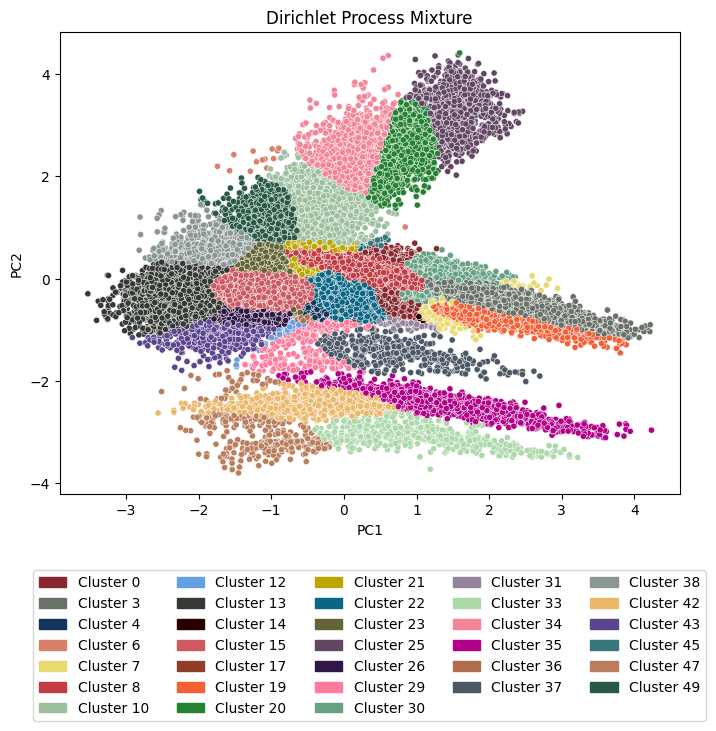

In [83]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('Dirichlet Process Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels_dpmm)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [84]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns = 'cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-1.163049,-2.596939,11,35
1,1.722822,-2.602608,11,35
2,1.451641,-2.588719,11,35
3,0.734407,-2.237956,11,35
4,0.121023,-2.182634,11,35


In [71]:
len(most_frequent_clusters.unique())

12

In [72]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-1.163049,-2.596939,11,35
1,1.722822,-2.602608,11,35
2,1.451641,-2.588719,11,35
3,0.734407,-2.237956,11,35
4,0.121023,-2.182634,11,35


In [73]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-1.163049,-2.596939,35
1,12,2.651199,-3.422293,33
2,13,1.451020,-0.049027,3
3,14,1.304045,-0.185737,3
4,15,2.222184,-0.592280,8
...,...,...,...,...
72,510,0.207552,2.331831,25
73,511,1.209865,3.228942,25
74,512,-0.236960,0.793759,25
75,513,1.510521,3.365319,25


In [74]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 3: [2, 3, 5, 6, 7, 8, 9, 11, 12, 15, 16, 18, 46, 48, 49, 50, 53, 54, 61]
Cluster 8: [4, 10, 20, 21, 22, 23, 25, 27, 28, 29, 31, 34, 35, 45, 47, 56, 57, 62, 65, 66, 67, 69, 70, 71]
Cluster 10: [39]
Cluster 15: [13, 17, 19, 24, 26, 30, 51, 55, 59, 60, 63, 64]
Cluster 19: [14]
Cluster 20: [37, 38, 42]
Cluster 22: [32, 68]
Cluster 25: [72, 73, 74, 75, 76]
Cluster 33: [1]
Cluster 34: [36, 40, 41, 43, 44]
Cluster 35: [0, 52, 58]
Cluster 37: [33]


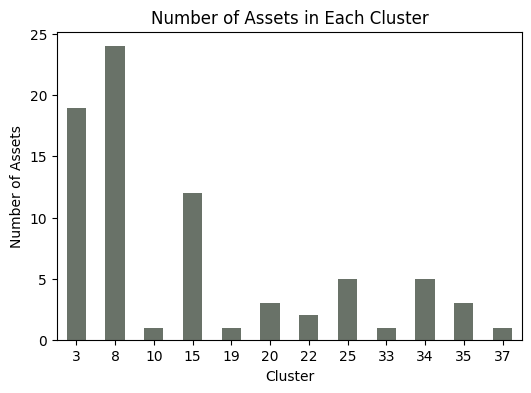

In [75]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [76]:
pca_df.to_csv('results/model_based/labels_most_common/dpmm.csv', index= False)